In [1]:
from data.dataset import REFLACXWithClinicalDataset
from model.xami import XAMIMultiModal
import torch
from utils.train import split_dataset, train, train_with_auc, RecordUnit, train_with_auc_margin_loss


In [2]:
# checking if the GPU is available
use_gpu = torch.cuda.is_available()

# setting up the device
device = 'cuda' if use_gpu else 'cpu'

print(f"Will be using {device}")


Will be using cuda


In [3]:
# load the dataset
reflacx_dataset = REFLACXWithClinicalDataset(image_size=256)

# keep the architecture simple, so we check the image nn first.
# prepare the model
xami_mutlimodal = XAMIMultiModal(
    reflacx_dataset,
    device,
    use_clinical=True,
    model_dim=64,
    embeding_dim=64,
    dropout=.2,  # increase the dropout rate did improve the regularization.
    pretrained=True
)
xami_mutlimodal = xami_mutlimodal.to(device)


Positive Loss weight:
[0.768546   0.78635013 0.7937685  0.8338279  0.87388724]
Negative Loss weight:
[0.231454   0.21364985 0.20623146 0.1661721  0.12611276]
Random Loss:
0.21026036153991162


In [4]:
xami_mutlimodal.num_all_params()


7041701

In [5]:
batch_size = 64

dataloaders = split_dataset(
    reflacx_dataset,
    batch_size,
    traing_portion=.8,
    test_portion=.1,
    seed=123
)

In [6]:
# lr = 1e-2



# optimizer = optim.Adam(
#     xami_mutlimodal.parameters(),
#     lr=lr,
#     weight_decay=1e-6
# )

# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
#                                                  patience=10,
#                                                  threshold=1e-3,
#                                                  factor=0.5
#                                                  )

# # scheduler = None


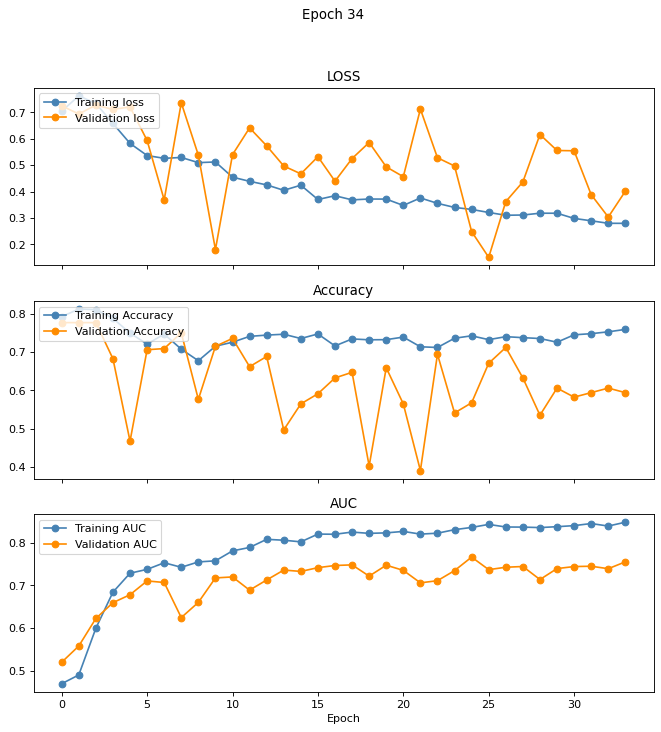


====================Current Learning Rate====================
| 0.02 

| Training Confusion Matrix 

| Enlarged cardiac silhouette 
              Pred_False  Pred_True
Target_False         269        142
Target_True            4        124

| Atelectasis 
              Pred_False  Pred_True
Target_False         288        135
Target_True           10        106

| Pleural abnormality 
              Pred_False  Pred_True
Target_False         365         66
Target_True           15         93

| Consolidation 
              Pred_False  Pred_True
Target_False         374         77
Target_True            6         82

| Pulmonary edema 
              Pred_False  Pred_True
Target_False         278        194
Target_True            1         66

| Validation Confusion Matrix 

| Enlarged cardiac silhouette 
              Pred_False  Pred_True
Target_False          19         32
Target_True            0         17

| Atelectasis 
              Pred_False  Pred_True
Target_False          22 

KeyboardInterrupt: 

In [7]:
train_data, val_data = train_with_auc_margin_loss(
    num_epochs=300,
    model=xami_mutlimodal,
    dataloaders=dataloaders,
    dataset=reflacx_dataset,
    device=device,
    lr=1e-1,
)


In [ ]:
# train_data, val_data = train_with_auc_margin_loss(
#     num_epochs=300,
#     model=xami_mutlimodal,
#     dataloaders=dataloaders,
#     lr=0.1,
#     dataset=reflacx_dataset,
#     device=device,
# )

# # if overfitting

# # Try


In [ ]:
# train_data, val_data = train(
#     num_epochs=300,
#     model=xami_mutlimodal,
#     dataloaders=dataloaders,
#     scheduler=scheduler,
#     dataset=reflacx_dataset,
#     optimizer=optimizer,
#     device=device,
#     early_stop_count=None,
#     loss_weighted=True,
# )
# # # if overfitting

# # # Try
# # # 1. dropout
# # # 2. learning scheduler?
# # # Change 1 parameters at a time.


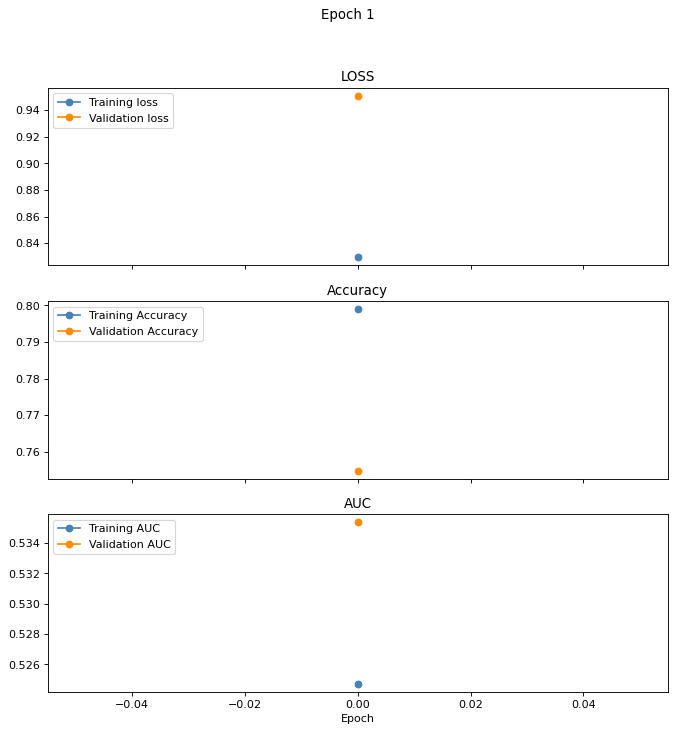

Current learning rate is 0.1
================Training CM================
Support devices
              Pred_False  Pred_True
Target_False         396          0
Target_True          143          0
Enlarged cardiac silhouette
              Pred_False  Pred_True
Target_False         411          0
Target_True          128          0
Atelectasis
              Pred_False  Pred_True
Target_False         423          0
Target_True          116          0
Pleural abnormality
              Pred_False  Pred_True
Target_False         431          0
Target_True          108          0
Consolidation
              Pred_False  Pred_True
Target_False         451          0
Target_True           88          0
Pulmonary edema
              Pred_False  Pred_True
Target_False         472          0
Target_True           67          0
================Validation CM================
Support devices
              Pred_False  Pred_True
Target_False          44          0
Target_True           24          0
Enl

In [ ]:
# train_data, val_data = train_with_auc(
#     num_epochs=300,
#     model=xami_mutlimodal,
#     dataloaders=dataloaders,
#     lr=1e-1,
#     dataset=reflacx_dataset,
#     device=device,
#     early_stop_count=None,
#     using_scheduler=False,
# )

# # if overfitting

# # Try
